<a href="https://colab.research.google.com/github/seungyoonnam/P_Project/blob/main/KoBERTmodel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#환경설정

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661778 sha256=6df06ffd37ff7895802d374637c36deaf9f9daae7fb780d3983f5c4f12d337a7
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 762.8 kB/s eta 0:00:00


In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-nhn0m59c/kobert-tokenizer_ca7d59f6579e4d0382e5309adf3ef445
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-nhn0m59c/kobert-tokenizer_ca7d59f6579e4d0382e5309adf3ef445
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=886597c8dae69ca62db29ca180b52d55767ac86a2eae1fba8aec588f2de3cf97
  Stored in directory: /tmp/pip-ephem-wheel-cache-ua2nbl9m/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
# Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
# GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

#Data

In [8]:
import json
import os

def load_data(data_dir):
    data = []
    files = os.listdir(data_dir)
    for filename in tqdm(files, desc="Loading data"):
        if filename.endswith('.json'):
            with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as f:
                json_data = json.load(f)
                news_title = json_data['sourceDataInfo']['newsTitle']
                news_content = json_data['sourceDataInfo']['newsContent']
                modified_text = ' '.join(news_content.split('\n'))
                clickbait_class = json_data['labeledDataInfo']['clickbaitClass']
                input_text = news_title + ' [SEP] ' + modified_text  # title과 content를 이어붙입니다. 모델이 제목과 본문을 구분할 수 있도록 [SEP] 토큰 삽입
                data.append([input_text, clickbait_class])
    return data

data_dir = '/content/drive/MyDrive/Colab Notebooks/pProject/source/newsdata'
data = load_data(data_dir)

Loading data: 100%|██████████| 36434/36434 [11:49<00:00, 51.36it/s] 


In [9]:
print(data[36000])

['한덕수 \\"퇴직 공무원 동원해 규제 혁신 별도 조직 만들 것\\" [SEP] 한덕수 국무총리가 은퇴한 공무원을 동원해 규제 혁신에 집중하는 별도의 조직을 만들겠다는 구상을 밝혔다. 한 총리는 25일 정부세종청사 국무조정실 기자실에서 출입기자단과 만나 \\"규제 개혁에 종사하는 인력 등 규모가 대폭 증가해야 한다고 본다\\"며 이같이 말했다. 규제 민원 업무를 하는 국무조정실 규제개혁위원회와 별도로 기업 활동에 제약이 되는 각종 규제를 발굴하고 완화하는 작업을 구체화하는 별동대 성격이 강한 조직이다. 규제 혁신을 위한 별도 조직이 \'콘트롤 타워\' 또는 \'자문기관\'이 아니라 부처들과 \'같이 일하는 조직\'이 될 것이라는 게 한 총리의 설명이다. 한 총리는 \\"각 부처가 이미 여러 측면에서 하고 있는 규제 혁신은 그대로 가고, 여기에 대통령이 추진하는 규제혁신추진회의 같은 것이 생길 것이고, 이에 더해 모든 대안을 검토하고 하는 것을 이 임시 조직이 할 것\\"이라고 소개했다. 한 총리는 실제 공직에서 일해본 퇴직 공무원의 전문성을 활용하고자 한다고 강조했다. 그는 \\"퇴직 공무원 중에는 수도권 개혁, 노동 개혁, 그곳에 들 예산까지도 다 추계한 분도 계시다\\"며 \\"이분들은 전임이 아니어도 계약직으로 모실 수 있고, 연금을 받으니 경비를 조금 적게 제공해도 운영할 수 있을 것으로 본다\\"고 설명했다. 한 총리는 윤석열 대통령이 정치인이 아닌 검사 출신인 것도 규제 혁신에 도움이 될 것이라고 했다. 한 총리는 \\"최고 통치권자가 규제 혁신의 자세한 선택안을 이해하고 자기 철학에 따라서 선택해줄 수 있어야 하는데, 일반적으로 정치적 과정으로 선출된 대통령께는 이를 이해시키기가 어려웠다\\"고 말했다. 그러면서 \\"윤 대통령이 수사 등을 할 때 본인이 이해하지 않고는 재판 과정이 진행될 수 없었을 테니 꼼꼼함이 있는 것 같다\\"며 \\"나아가 직접 누군가에게 전화해서 설득하는 것도 두려워하지 않는 것 같다\\"고 했다. 한 총리는 기업의 도

In [10]:
from sklearn.model_selection import train_test_split

# 데이터를 학습 데이터와 테스트 데이터, 검증데이터로 분할 => 각 8:1:1 비율
dataset_train, dataset_tmp = train_test_split(data, test_size=0.2, random_state=42)
dataset_test, dataset_val = train_test_split(dataset_tmp, test_size=0.5, random_state=42)

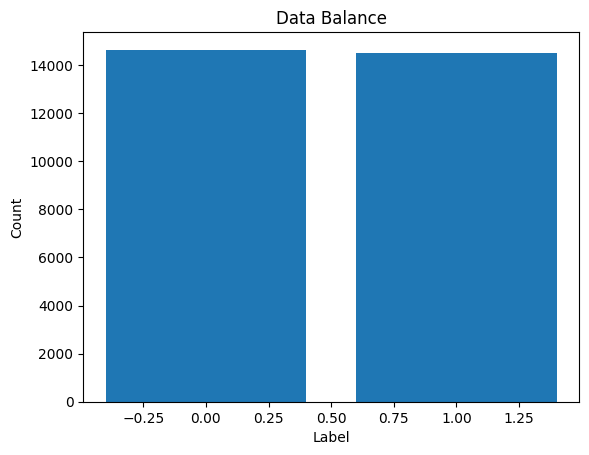

In [11]:
#학습데이터 밸런스 확인
import matplotlib.pyplot as plt

def visualize_data_balance(data):
    label_counts = {}
    for _, label in data:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Data Balance')
    plt.show()

visualize_data_balance(dataset_train)

In [12]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [13]:
# Setting parameters
max_len = 256
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [14]:
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [15]:
#torch로 전환
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=3)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Model

###사전학습 Model 불러오기

In [16]:
#사전학습된 kobert 모델
print(bertmodel)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
   

###finetuning

In [17]:
#이진분류
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2, #clickbait 0,1 이진분류
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [18]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
print(model)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

#Train 1

In [19]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [21]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-21-e6a38b13095b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/911 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 1 batch id 1 loss 0.7277776002883911 train acc 0.5
epoch 1 batch id 201 loss 0.7282565236091614 train acc 0.5102611940298507
epoch 1 batch id 401 loss 0.6166916489601135 train acc 0.5404457605985037
epoch 1 batch id 601 loss 0.6323186755180359 train acc 0.5587042429284526
epoch 1 batch id 801 loss 0.5523675084114075 train acc 0.5718632958801498
epoch 1 train acc 0.5776885900719599


<ipython-input-21-e6a38b13095b>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/114 [00:00<?, ?it/s]

epoch 1 test acc 0.6590826023391814


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6568149328231812 train acc 0.625
epoch 2 batch id 201 loss 0.5359877943992615 train acc 0.6305970149253731
epoch 2 batch id 401 loss 0.58509361743927 train acc 0.6324812967581047
epoch 2 batch id 601 loss 0.5194876194000244 train acc 0.6462666389351082
epoch 2 batch id 801 loss 0.4713936746120453 train acc 0.6540652309612984
epoch 2 train acc 0.6558841017197219


  0%|          | 0/114 [00:00<?, ?it/s]

epoch 2 test acc 0.6779260071474983


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6325749754905701 train acc 0.65625
epoch 3 batch id 201 loss 0.646008312702179 train acc 0.6881218905472637
epoch 3 batch id 401 loss 0.6261343359947205 train acc 0.6936564837905237
epoch 3 batch id 601 loss 0.47281935811042786 train acc 0.7074667221297837
epoch 3 batch id 801 loss 0.4018872082233429 train acc 0.7189450686641697
epoch 3 train acc 0.721883004024881


  0%|          | 0/114 [00:00<?, ?it/s]

epoch 3 test acc 0.6823627355425601


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6148030757904053 train acc 0.65625
epoch 4 batch id 201 loss 0.564215362071991 train acc 0.7476679104477612
epoch 4 batch id 401 loss 0.6047170758247375 train acc 0.7625467581047382
epoch 4 batch id 601 loss 0.31831684708595276 train acc 0.7767262895174709
epoch 4 batch id 801 loss 0.20829881727695465 train acc 0.7889357053682896
epoch 4 train acc 0.790913271943733


  0%|          | 0/114 [00:00<?, ?it/s]

epoch 4 test acc 0.6872969460688758


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.481492280960083 train acc 0.8125
epoch 5 batch id 201 loss 0.4879719018936157 train acc 0.8123445273631841
epoch 5 batch id 401 loss 0.4154093861579895 train acc 0.8195137157107232
epoch 5 batch id 601 loss 0.2788046598434448 train acc 0.8309068219633944
epoch 5 batch id 801 loss 0.31776300072669983 train acc 0.8379369538077404
epoch 5 train acc 0.8392309021425377


  0%|          | 0/114 [00:00<?, ?it/s]

epoch 5 test acc 0.6874695419103314


In [22]:
#save model
torch.save(model, '/content/drive/MyDrive/pProject/KoBERTClassModel_01.pth')

#ROC Curve

threshold의 기준은 Youden's J statistic

In [23]:
data_val = BERTDataset(dataset_val, 0, 1, tok, vocab, max_len, True, False)

#torch로 전환
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<ipython-input-28-53a56d5a32f7>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


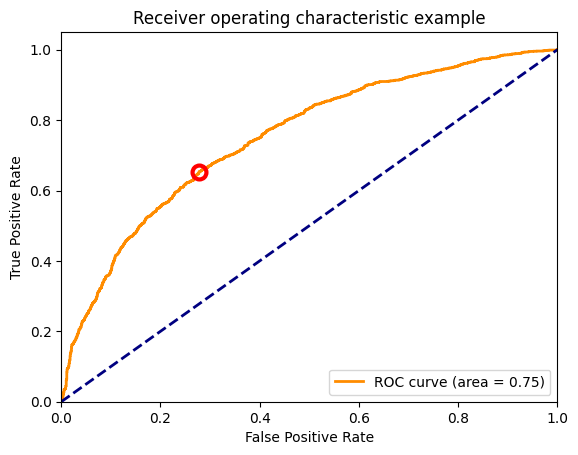

AUC:  0.7498674470420807
Optimal Threshold:  0.22669780254364014


In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_test = []
y_pred = []
with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        output = model(token_ids, valid_length, segment_ids)
        y_pred.extend(output[:, 1].cpu().numpy().tolist())
        y_test.extend(label.cpu().numpy().tolist())

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Youden's J statistic을 사용하여 최적의 임계값을 찾습니다.
J = tpr - fpr
opt_idx = np.argmax(J)
opt_threshold = thresholds[opt_idx]
opt_fpr = fpr[opt_idx]
opt_tpr = tpr[opt_idx]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(opt_fpr, opt_tpr, 'o', markersize=10, fillstyle='none', c='r', mew=3)  # 최적의 임계값을 표시합니다.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print("AUC: ", roc_auc)
print("Optimal Threshold: ", opt_threshold)


#참고
https://complexoftaste.tistory.com/2